# Figure 2 (Baseline Analysis)

In [8]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [9]:
# Replace with the path to where you store data
DATA_PATH = "../../cnt-data/"

In [10]:
# This is the example patient's HUP ID
patient_hup_id = 142

# Load in the patient's "giant table"
hourly_patient_features_df = pd.read_csv(
    os.path.join(DATA_PATH, f"giant_new_tables/HUP_{str(patient_hup_id)}.csv")
)

## Figure 2 (C)

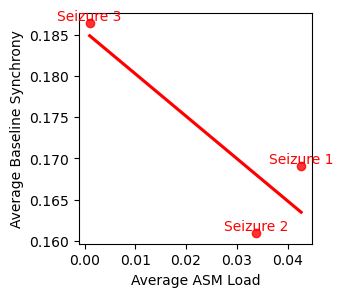

In [11]:
# Assuming you have the hourly_patient_features_df from somewhere above
seizure_indices = hourly_patient_features_df[
    hourly_patient_features_df["had_seizure"] >= 1
].index

valid_seizure_indices = [
    idx
    for i, idx in enumerate(seizure_indices)
    if i == 0 or (seizure_indices[i] - seizure_indices[i - 1]) >= 120
]

avg_synchronies = []
avg_med_loads = []

for idx in valid_seizure_indices:
    seizure_time = hourly_patient_features_df.loc[idx, "emu_minute"]

    window = hourly_patient_features_df[
        (hourly_patient_features_df["emu_minute"] >= seizure_time - 120)
        & (hourly_patient_features_df["emu_minute"] < seizure_time - 20)
    ]

    avg_synchrony = np.nanmean(window["synchrony_broadband"])
    avg_med_load = np.nanmean(window["med_sum_no_lorazepam_raw"])

    avg_synchronies.append(avg_synchrony)
    avg_med_loads.append(avg_med_load)

if avg_med_loads and avg_synchronies:
    plt.figure(figsize=(3, 3))  # Add this line to create a standalone figure
    sns.regplot(
        x=avg_med_loads,
        y=avg_synchronies,
        scatter=True,
        line_kws={"color": "red"},
        ci=None,
        color="red",
    )

    # Label each dot with its respective seizure number
    for i, (x, y) in enumerate(zip(avg_med_loads, avg_synchronies)):
        plt.text(
            x, y, f"Seizure {i+1}", fontsize=10, ha="center", va="bottom", color="red"
        )

    plt.xlabel("Average ASM Load")
    plt.ylabel("Average Baseline Synchrony")
    # plt.title(f"Baseline Synchrony vs ASM")
    plt.show()  # Add this line to display the plot

## Figure 2 (D)

## Figure 2 (E)